In [3]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### 1) Data Description

The provided dataset for this assignment consists of two csv files, ```players.csv``` and ```sessions.csv```.

As shown below in ```overview```, ```players``` consists of 196 players and 7 variables, and ```sessions``` consists of 1535 sessions and 5 variables. Further details are described in the next few blocks of code & markdown cells:

In [4]:
# reading the files
players <- read_csv('players.csv', show_col_types = FALSE)
sessions <- read_csv('sessions.csv', show_col_types = FALSE)

# quick overview of datasets
overview <- tibble(dataset = c("players.csv", "sessions.csv"),
                  n_rows = c(nrow(players), nrow(sessions)),
                  n_cols = c(ncol(players), ncol(sessions)))
overview

dataset,n_rows,n_cols
<chr>,<int>,<int>
players.csv,196,7
sessions.csv,1535,5


In ```players.csv```, each observation consists of **one unique player**, identified by a ```hashedEmail```. In total, there are 196 unique players in this dataset. Other demographic information per player is included, as described below in ```players_variables```:

In [5]:
## variables in players.csv
players_variables <- tibble(variable = names(players), 
                            type = map_chr(players, ~class(.x)[1]),
                            description = c("Players's experience level (Amateur, Veteran, Pro)",
                                            "The player's subscription status to the newsletter",
                                            "The player's anonymized e-mail",
                                            "The total number of hours played",
                                            "The player's name",
                                            "The player's gender",
                                            "The player's age"))
players_variables

variable,type,description
<chr>,<chr>,<chr>
experience,character,"Players's experience level (Amateur, Veteran, Pro)"
subscribe,logical,The player's subscription status to the newsletter
hashedEmail,character,The player's anonymized e-mail
played_hours,numeric,The total number of hours played
name,character,The player's name
gender,character,The player's gender
Age,numeric,The player's age


Summary statistics for ```played_hours``` and ```Age``` are stored in ```hours_stats``` and ```age_stats```, respectively (see below). From here, I can already identify some potential issues with the data:

For ```played_hours```:
- ```min_hours``` is zero, which means that some players registered but never played. This indicates that some data might be missing or invalid.
- ```max_hours``` is 223.1, which indicates that the data is extremely positively skewed. This points to potential outliers, and subsequently, ```mean_hours``` may be inflated.

For ```Age```:
- There seems to be less obvious issues overall, although I had to use ```na.rm = TRUE```. This means that some players did not report their age. This might be problematic because it could lead to bias and reduces the sample size. 

In [6]:
## summary statistics for played_hours and Age
hours_stats <- players |>
  summarise(min_hours = round(min(played_hours, na.rm = TRUE), 2),
    max_hours = round(max(played_hours, na.rm = TRUE), 2),
    mean_hours = round(mean(played_hours, na.rm = TRUE), 2),
    median_hours = round(median(played_hours, na.rm = TRUE), 2),
    total_players = n())

age_stats <- players |>
  summarise(min_age = round(min(Age, na.rm = TRUE), 2),
    max_age = round(max(Age, na.rm = TRUE), 2),
    mean_age = round(mean(Age, na.rm = TRUE), 2),
    median_age = round(median(Age, na.rm = TRUE), 2),
    total_players = n())

hours_stats
age_stats

min_hours,max_hours,mean_hours,median_hours,total_players
<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,223.1,5.85,0.1,196


min_age,max_age,mean_age,median_age,total_players
<dbl>,<dbl>,<dbl>,<dbl>,<int>
9,58,21.14,19,196


In ```sessions.csv```, each row is information about **one session**. The identifying ```hashedEmail``` is included per play session, so this information can be mapped back to ```players.csv```. In total, there are 1535 observations in this dataset. There are 5 columns in this dataset, described below in ```sessions_variables```:

In [7]:
sessions_variables <- tibble(variable = names(sessions),
                             type = map_chr(sessions, ~class(.x)[1]),
                             description = c("The player's anonymized e-mail",
                                             "session start time (dd/mm/yyyy hh/mm)",
                                             "session end time (dd/mm/yyyy hh/mm)",
                                             "UNIX start time",
                                             "UNIX end time"))
sessions_variables

variable,type,description
<chr>,<chr>,<chr>
hashedEmail,character,The player's anonymized e-mail
start_time,character,session start time (dd/mm/yyyy hh/mm)
end_time,character,session end time (dd/mm/yyyy hh/mm)
original_start_time,numeric,UNIX start time
original_end_time,numeric,UNIX end time


Once again, summary statistics for ```sessions``` are shown below in ```sessions_stats```. The data was grouped by player (```hashedEmail```) to get information about number of sessions per player. Here, I noticed that ```min_sessions``` is 1, which indicates that ```players``` with 0 hours were not included. 

Some potential problems with ```sessions.csv``` might include:
- ```min_sessions``` and ```median_sessions``` are both 1, and ```max_sessions``` is 310. This indicates an extremely strong positive skew. Similar to ```players.csv```, the mean may be inflated.
- This also points to another issue: since half the players only played 1 time, this provides no replicates per individual (no biological replicates).

In [8]:
sessions_info <- sessions |>
    group_by(hashedEmail) |>
    summarise(count = n())

sessions_stats <- sessions_info |>
    summarise(min_sessions = min(count),
    max_sessions = max(count),
    mean_sessions = mean(count),
    median_sessions = median(count),
    total_players = n())

sessions_stats

min_sessions,max_sessions,mean_sessions,median_sessions,total_players
<int>,<int>,<dbl>,<int>,<int>
1,310,12.28,1,125


In [9]:
## histograms for played_hours and Age
hours_plot <- players |>
    ggplot(aes(x = played_hours)) +
    geom_histogram(bins = 50,
                   aes(y = after_stat(count/sum(count) * 100))) +
    labs(title = 'Distribution of Hours Played',
         x = 'Hours Played',
         y = 'Percent Total Players (%)') +
    theme(plot.title = element_text(hjust = 0.5))

age_plot <- players |>
    ggplot(aes(x = Age)) +
    geom_histogram(bins = 50,
                   aes(y = after_stat(count/sum(count) * 100))) +
    labs(title = 'Distribution of Player Age',
         x = 'Age (years)',
         y = 'Percent Total Players (%)') +
    theme(plot.title = element_text(hjust = 0.5))

### 2) Questions

**Broad Question 1**: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

**Specific Question**: Are players who play more often during certain times of day (mornings/afternoons/evenings) more likely to subscribe to the newsletter?


The predictor variable will be proprtion of hours or sessions in morning/afternoon/night time windows, in ```sessions.csv```. The subscription information is in ```players.csv```. This will be a **predictive classification** question because the outcome variable, 'subscribe', is binary. I can also include other variables (age, experience) as control variables. This problem fits the logistic regression model we learned in class. 

### 3) Exploratory Data Analysis and Visualization

**1) Demonstrate that the dataset can be loaded into R**\
The code below reads both datasets, ```players.csv``` and ```sessions.csv``` into the variables ```players``` and ```sessions```, respectively. I used ```head()``` to inspect these datasets:

In [10]:
players <- read_csv('players.csv', show_col_types = FALSE)
sessions <- read_csv('sessions.csv', show_col_types = FALSE)

head(players, 3)
head(sessions, 3)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12


**2) Do the minimum necessary wrangling to turn your data into a tidy format. Do not do any additional wrangling here; that will happen later during the group project phase**

The ```players``` dataset is already in tidy format, while the ```sessions``` dataset is not.
In ```sessions```, we can see that ```start_time``` and ```end_time``` variables have the date _and_ time within one column. This violates the rule for tidy data which states that there should only be one observation per cell. Thus, to clean this, I used ```separate()``` to split these two columns into four columns: ```start/end_date``` and ```start/end_time``` by a ' '. The tidy data is stored in ```sessions_tidy```.

In [11]:
sessions_tidy <- sessions |> 
    separate(start_time, into = c('start_date', 'start_time'), sep = ' ') |>
    separate(end_time, into = c('end_date', 'end_time'), sep = ' ')
head(sessions_tidy, 5)

hashedEmail,start_date,start_time,end_date,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024,18:12,30/06/2024,18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024,23:33,17/06/2024,23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024,17:34,25/07/2024,17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024,03:22,25/07/2024,03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024,16:01,25/05/2024,16:12,1.71665e+12,1.71665e+12


**3) Compute the mean value for each quantitative variable in the players.csv data set. Report the mean values in a table format.**

By inspecting players.csv, we can see that the two quantitative variables (```dbl```) are ```played_hours``` and ```Age```. The mean values are stored in ```players_summary``` below:

In [12]:
players_summary <- players |>
    summarise(
        mean_hours = round(mean(played_hours, na.rm = TRUE), 2),
        mean_age = round(mean(Age, na.rm = TRUE),2))
players_summary

mean_hours,mean_age
<dbl>,<dbl>
5.85,21.14


**4) Make a few exploratory visualizations of the data to help you understand it**

First, I generate three histograms for ```played_hours```, ```Age``` from ```players.csv```, and another for number of sessions per player from ```sessions.csv```. These plots are useful to help visualize the descriptive statistics from Questions 1) and 3):

_*Due to positive skewness, a log10 scale was applied to the x-axis for ```hours_hist``` and ```sessions_hist``` to better visualize the lower values_

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


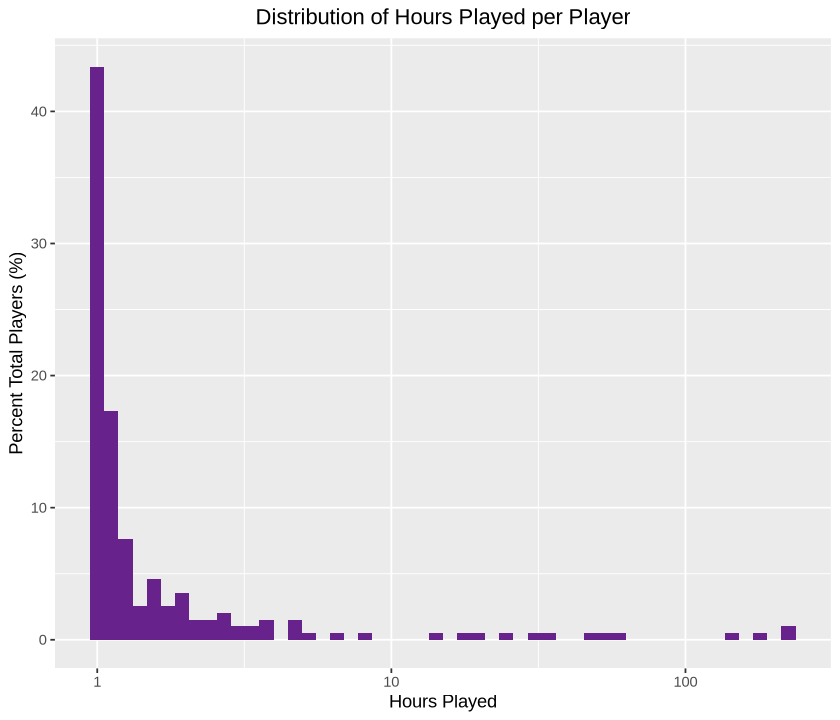

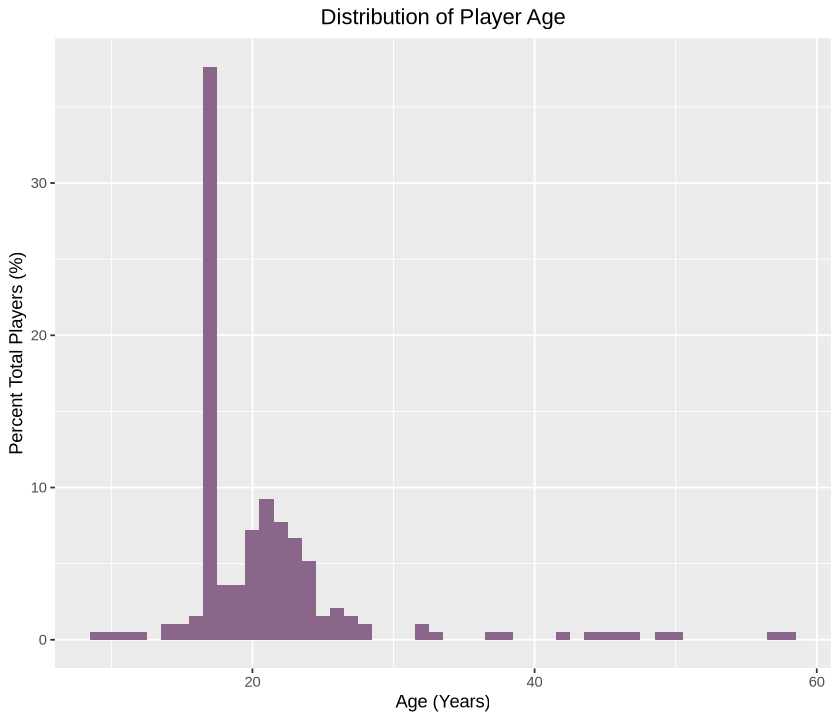

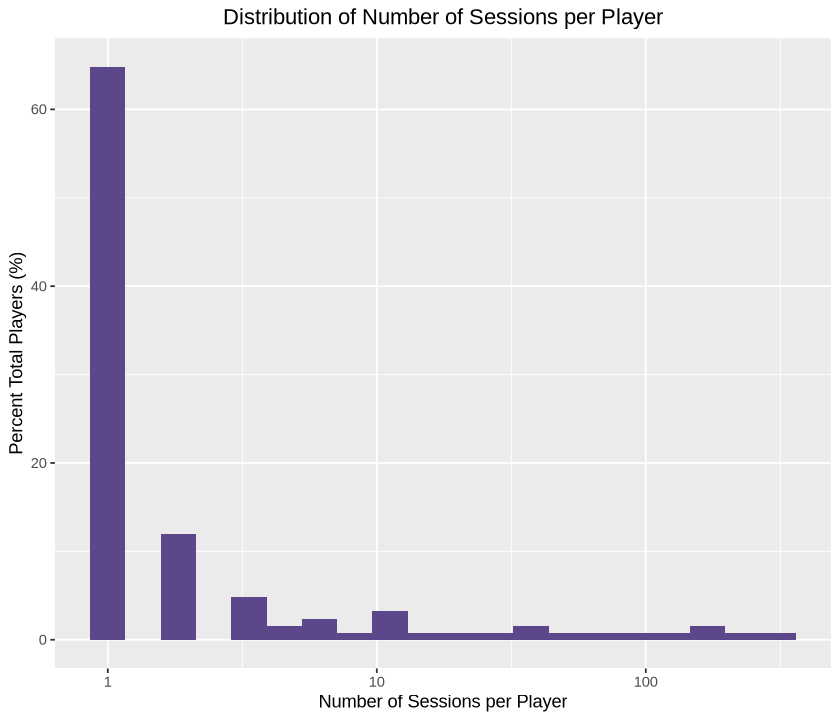

In [111]:
options(repr.plot.width = 7, repr.plot.height = 6)

## create histogram of hours played per player
hours_hist <- players |>
    ggplot(aes(x = played_hours + 1)) +
    geom_histogram(bins = 50,
                   aes(y = after_stat(count/sum(count) * 100)),
                  fill = 'darkorchid4') +
    labs(title = 'Distribution of Hours Played per Player',
         x = 'Hours Played',
         y = 'Percent Total Players (%)') +
    scale_x_log10() +
    theme(plot.title = element_text(hjust = 0.5))
hours_hist

## create histogram of players' ages
age_hist <- players |>
    ggplot(aes(x = Age)) +
    geom_histogram(bins = 50,
                   aes(y = after_stat(count/sum(count) * 100)),
                  fill = 'plum4') +
    labs(title = 'Distribution of Player Age',
         x = 'Age (Years)',
         y = 'Percent Total Players (%)') +
    theme(plot.title = element_text(hjust = 0.5))
age_hist

## create histogram of number of sessions per player
sessions_hist <- sessions_info |>
  ggplot(aes(x = count)) +
  geom_histogram(bins = 20,
                aes(y = after_stat(count/sum(count) * 100)),
                fill = 'mediumpurple4') + 
    scale_x_log10() +
    labs(title = 'Distribution of Number of Sessions per Player',
         x = 'Number of Sessions per Player',
         y = 'Percent Total Players (%)') + 
    theme(plot.title = element_text(hjust = 0.5))
sessions_hist

Next, in ```players.csv``` I wanted to see if there is any relationship between ```played_hours``` and ```Age```. I also coloured by ```subscribe```, as this might give me some insight into my research question:

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


subscribe,n,pct
<lgl>,<int>,<dbl>
FALSE,52,26.53
TRUE,144,73.47


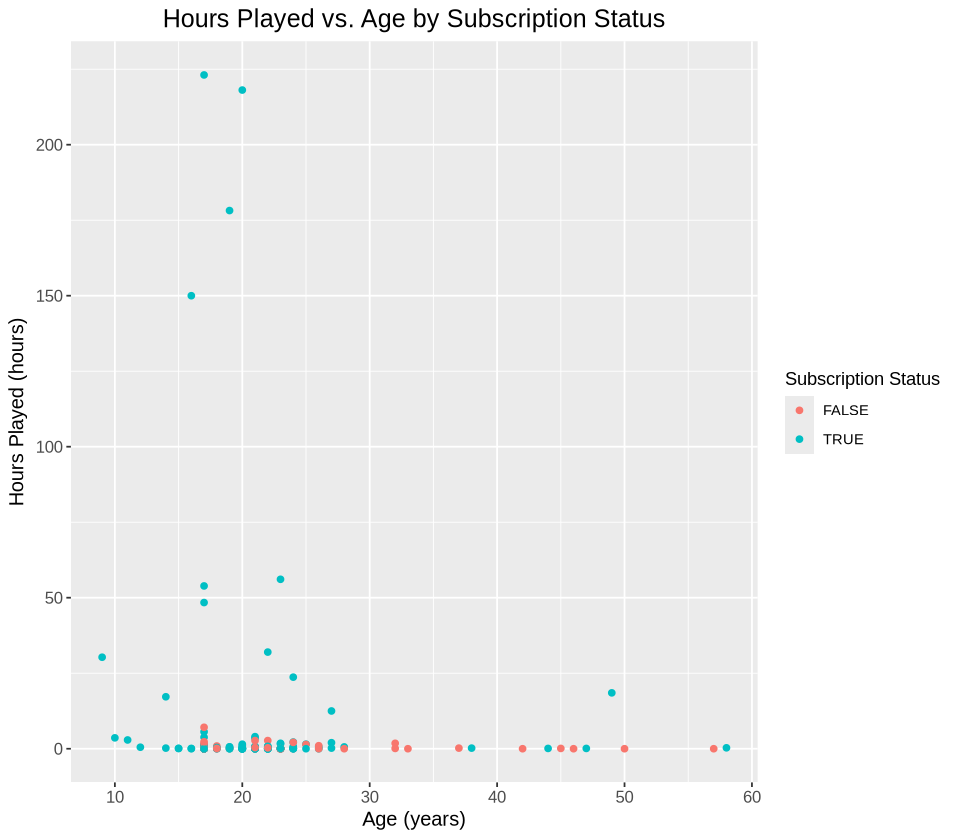

In [66]:
options(repr.plot.height = 7, repr.plot.width = 8)

## create plot of hours played vs age, group by subscription status
age_hours_plot <- players |> 
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point() + 
    labs(title = 'Hours Played vs. Age by Subscription Status', 
         x = 'Age (years)',
         y = 'Hours Played (hours)',
        color = 'Subscription Status') + 
    theme(plot.title = element_text(size = 15, hjust = 0.5),
         axis.title = element_text(size = 12),
         axis.text = element_text(size = 10))

age_hours_plot

## summarise pct players where subscribe = TRUE/FALSE:
pct_true <- players |>
  count(subscribe) |>
  mutate(pct = round(n/sum(n)*100,2))
pct_true

```age_hours_plot``` shows non apparent relationship between hours played and age. However, it appears that players where ```subscribe = TRUE``` play for longer times, regardless of age. To investigate this, I generate another plot below (```sub_hours_plot```) and, players that have subscribed seem to play for a greater number of hours. However, since the data seemed to be heavily skewed, this difference may not be significant: by using ```geom_boxplot``` and from our summary statistics, we know that the means are not that different.

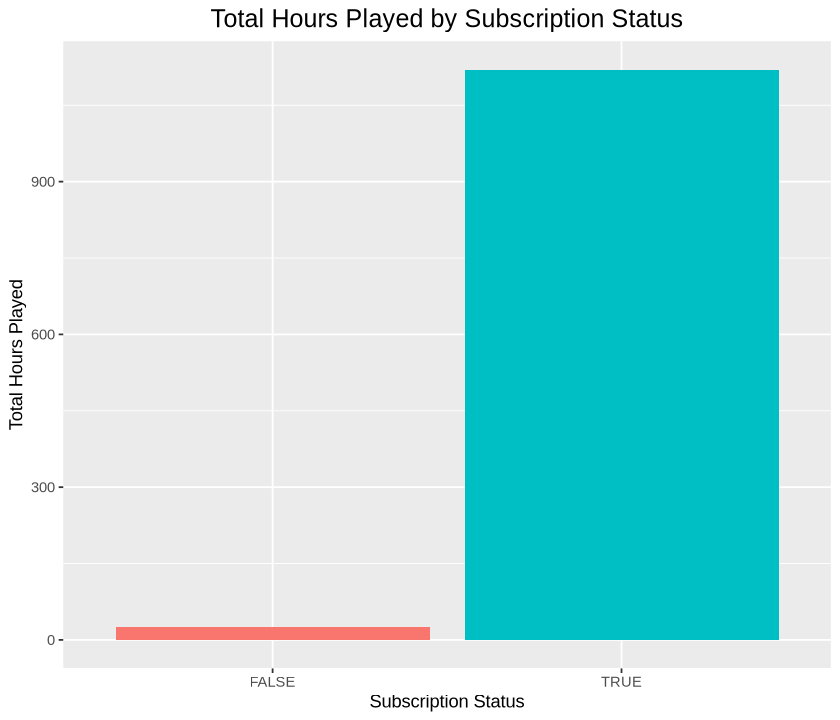

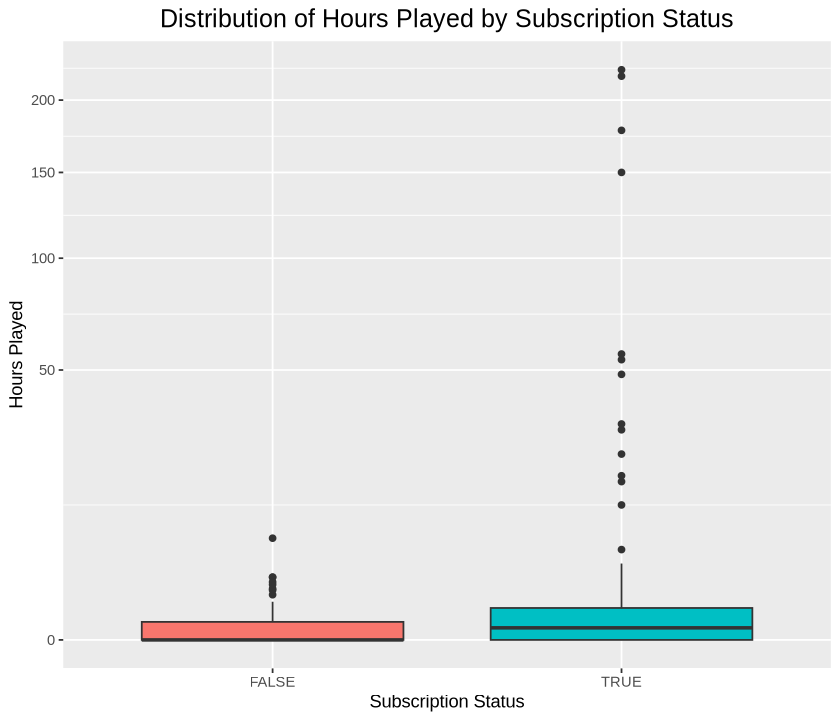

In [106]:
## create bar chart
sub_hours_bar <- players |>
    ggplot(aes(x = subscribe, y = played_hours, fill = subscribe)) +
    geom_bar(stat = "identity") +
    labs(title = "Total Hours Played by Subscription Status",
         x = "Subscription Status", 
         y = "Total Hours Played") +
    theme(plot.title = element_text(hjust = 0.5, size = 15),
         legend.position = 'none')
sub_hours_bar


## create box plot
sub_hours_box <- players |> 
    ggplot(aes(x = subscribe, y = played_hours, fill = subscribe)) +
    geom_boxplot() +
    labs(title = "Distribution of Hours Played by Subscription Status",
         x = "Subscription Status",
         y = "Hours Played") + 
    scale_y_sqrt() +
    theme(plot.title = element_text(hjust = 0.5, size = 15),
         legend.position = "none")
sub_hours_box

## 4) Methods and Plan